In [1]:
import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KNeighborsClassifier as KNN

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [3]:
dataset = pd.read_csv('peripheral_analyzer.csv')

In [4]:
dataset.head()

Unnamed: 0  target  h_target     scen_std    scen_mean  scen_noise  \
0           0     0.0       0.0  1575.499326  2871.029964    1.822298   
1           1    14.0       0.0  1070.285274  3840.850456    3.588623   
2           2    36.0       1.0   523.284054  3794.610431    7.251531   
3           3    36.0       1.0   417.525843  3779.685520    9.052579   
4           4    19.0       1.0   219.969848   851.458736    3.870797   

    sband_std   sband_mean  sband_noise     sflat_std      ...        \
0  719.953745  1776.729320     2.467838  3.303435e-01      ...         
1  579.544414  3408.730932     5.881742  4.944854e-06      ...         
2  343.696932  3412.485492     9.928763  2.176866e-03      ...         
3  228.752348  3414.288079    14.925696  6.168334e-03      ...         
4  160.752499   613.166437     3.814351  6.067242e-08      ...         

   mfcc_10_noise  mfcc_11_std  mfcc_11_mean  mfcc_11_noise  mfcc_12_std  \
0      -0.692105     0.465543      0.925566       1.159265     1.013613   
1       0.814727     0.684843      0.501333       0.719368     0.494695   
2       1.463375     1.311490      2.692181       1.143830     2.230121   
3       1.489876     1.388678      2.197716       1.135417     1.957357   
4       1.149906     1.244574      1.129034       0.750682     0.263017   

   mfcc_12_mean  mfcc_12_noise  mfcc_13_std  mfcc_13_mean  mfcc_13_noise  
0      0.807174       0.460495    -0.272164      0.195132       0.999330  
1      0.538048       0.787442     0.277811      0.518634       1.185178  
2      0.368222       1.683238     2.396500      2.400763       2.726664  
3      0.380601       1.700826     2.098996      2.510292       2.365515  
4     -0.162094      -0.430786    -0.568510     -0.613582      -0.591416  

[5 rows x 57 columns]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [6]:
dataset.describe()

Unnamed: 0       target     h_target     scen_std    scen_mean  \
count  6049.000000  6049.000000  6049.000000  6049.000000  6049.000000   
mean   3996.469830    23.912713     0.578443   725.417747  1675.806816   
std    2266.008383    13.608810     0.493849   532.516239  1253.594459   
min       0.000000     0.000000     0.000000     0.365671     0.380919   
25%    2056.000000    14.000000     0.000000   281.296952   605.664466   
50%    4019.000000    25.000000     1.000000   651.962725  1510.504694   
75%    5969.000000    33.000000     1.000000  1104.704910  2550.317195   
max    7892.000000    49.000000     1.000000  2581.005583  6198.670629   

        scen_noise    sband_std   sband_mean  sband_noise     sflat_std  \
count  6049.000000  6049.000000  6049.000000  6049.000000  6.049000e+03   
mean      4.056629   566.939620  1371.110291     7.479270  1.318590e-01   
std      13.325731   461.056073   961.669549    38.756345  1.907713e-01   
min       0.160128     0.233266     0.650233     0.106542  6.203558e-11   
25%       1.106481   179.842133   611.183330     1.148639  7.969231e-07   
50%       1.946317   470.625913  1296.153955     2.097732  1.674202e-04   
75%       3.924598   863.106736  1956.196386     4.686881  3.142075e-01   
max     571.209313  2375.100798  4763.266542  1920.176518  5.000000e-01   

           ...        mfcc_10_noise   mfcc_11_std  mfcc_11_mean  \
count      ...          6049.000000   6049.000000   6049.000000   
mean       ...             1.518007      7.346211      1.181047   
std        ...            36.704426    485.635530     30.156981   
min        ...           -29.011908    -61.769088  -1295.265625   
25%        ...             0.376994      0.447188      0.500000   
50%        ...             0.859155      0.881326      0.909237   
75%        ...             1.286599      1.292812      1.290882   
max        ...          2798.714523  37769.040559   1922.890811   

       mfcc_11_noise  mfcc_12_std  mfcc_12_mean  mfcc_12_noise  mfcc_13_std  \
count    6049.000000  6049.000000   6049.000000    6049.000000  6049.000000   
mean        1.487917     1.196425      1.093219       0.999837     1.034519   
std        31.405259     8.523687      5.675809       5.165744     5.704382   
min      -394.814884   -28.558145    -29.022153     -38.080799  -208.080186   
25%         0.476576     0.472829      0.450502       0.374783     0.445338   
50%         0.880814     0.873060      0.855993       0.819370     0.842768   
75%         1.258426     1.260211      1.246489       1.184773     1.220028   
max      2188.597019   544.366033    375.848748     278.193559   221.101224   

       mfcc_13_mean  mfcc_13_noise  
count   6049.000000    6049.000000  
mean       1.122979       0.939641  
std       11.042154       3.871204  
min      -12.565998    -105.513505  
25%        0.477000       0.440506  
50%        0.854197       0.821756  
75%        1.213123       1.165083  
max      827.775989     141.633370  

[8 rows x 57 columns]

In [12]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df, test_size=0.20, random_state=42)

In [13]:
train_X = train.drop(['target', 'h_target'], axis=1)
train_y = train['l_target']
test_X = test.drop(['target', 'h_target'], axis=1)
test_y = test['l_target']

# KNN Grid Search

In [14]:
from sklearn.model_selection import GridSearchCV
params = {
          'n_neighbors': range(5,25,1),
          'algorithm': ('ball_tree', 'kd_tree', 'brute')
         }

knn = KNN(n_neighbors=15, algorithm='ball_tree')

clf = GridSearchCV(knn, params, cv=5)

clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'algorithm': ('ball_tree', 'kd_tree', 'brute'), 'n_neighbors': range(5, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_algorithm',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.8257121439280359
Confusion matrix, without normalization
[[ 657  288]
 [ 177 1546]]


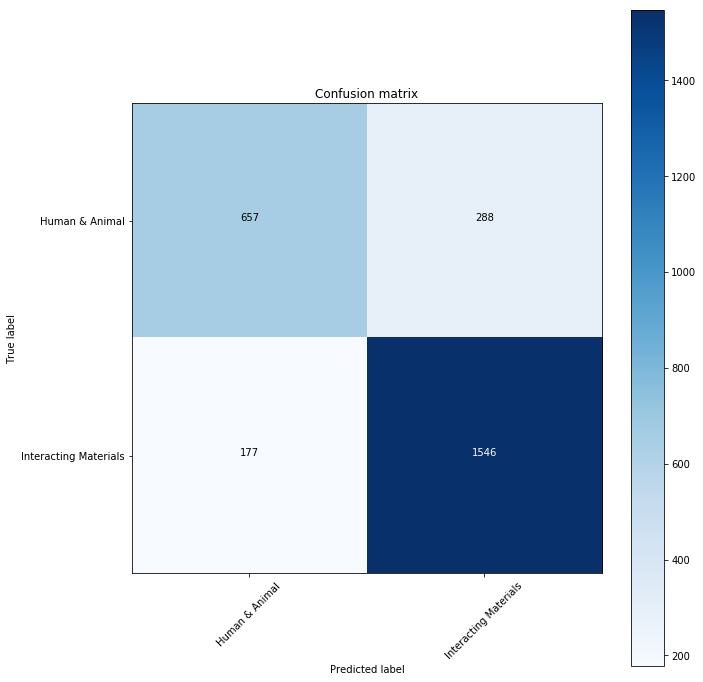

In [16]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [17]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 61ms/step - loss: 1.2465
Epoch 1/1
2/2 [==============================] - 0s 58ms/step - loss: 1.3345
	Bytes: 3067120
	Processing Time: 13.022420883178711


In [18]:
X = all_df.drop(['l_target', 'h_target'], axis=1)
y = all_df['l_target']

0.6496217851739788
Confusion matrix, without normalization
[[ 573  655]
 [ 503 1574]]


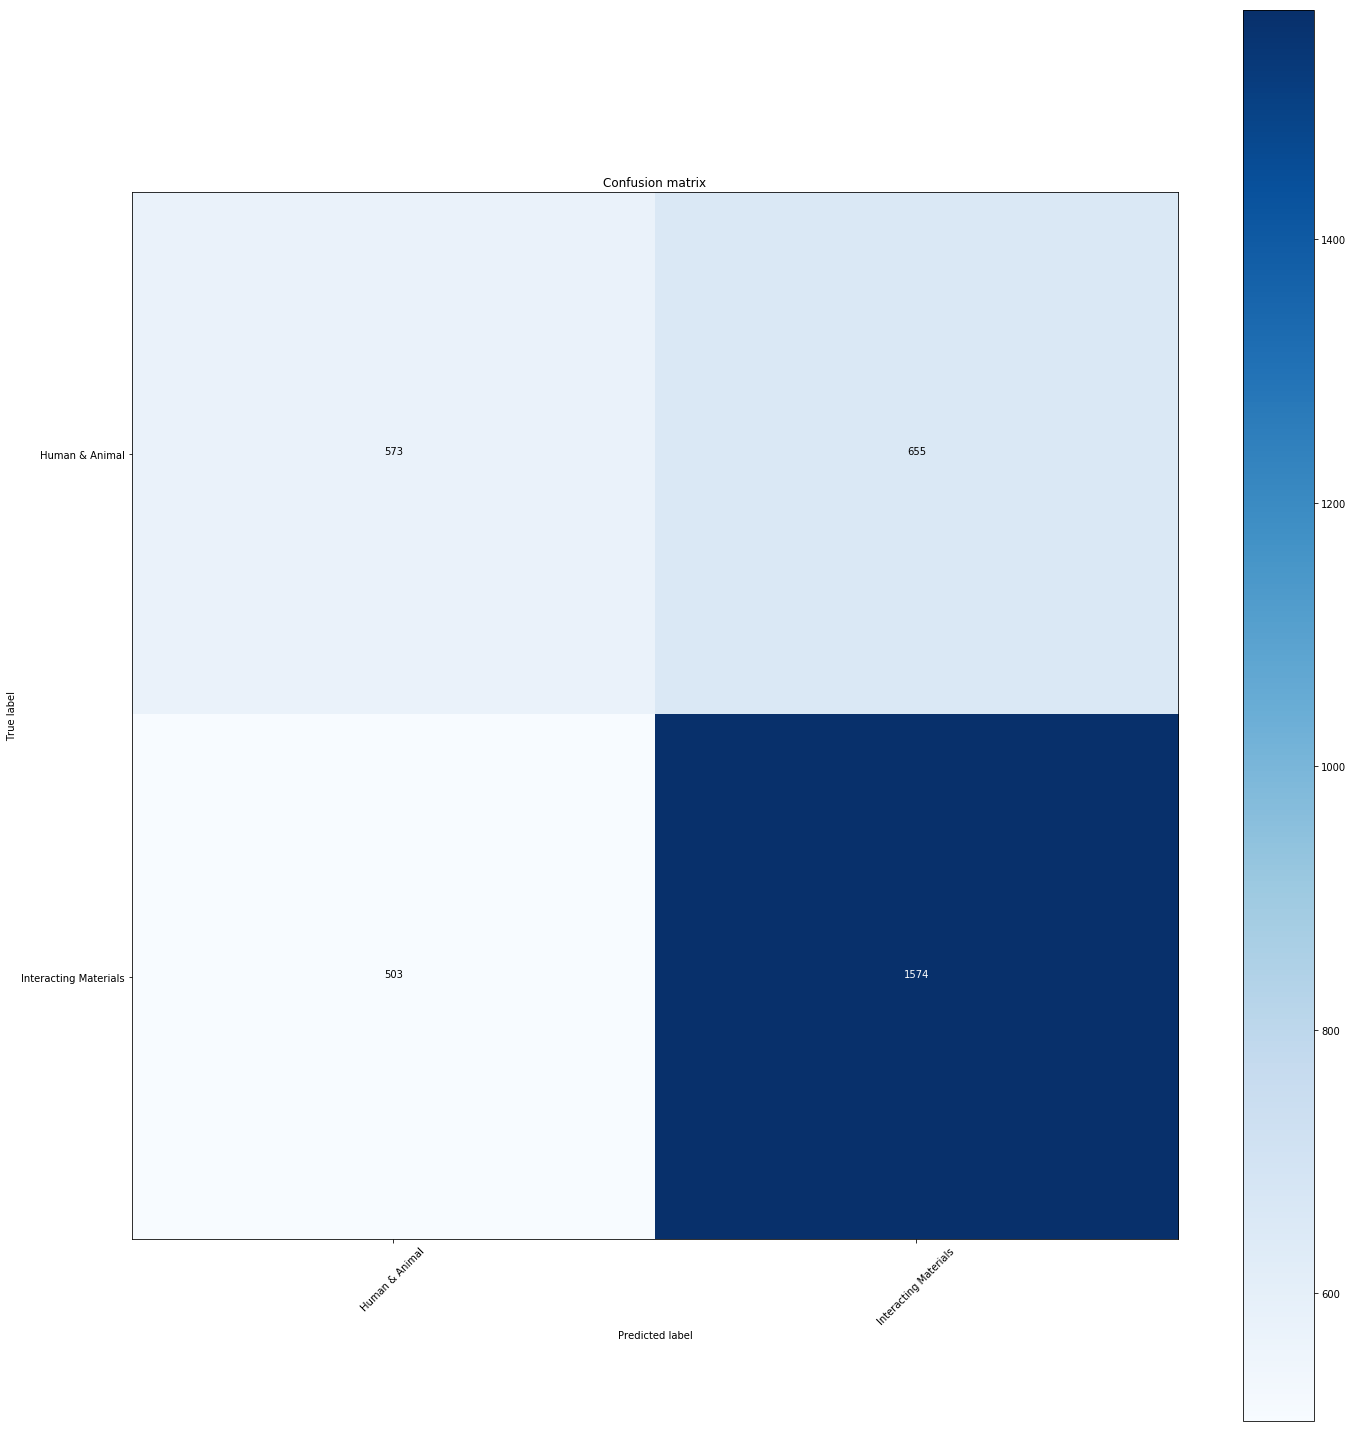

In [19]:
pred = clf.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, h_classes)
plt.show()